In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

In [2]:
############################## UTIL FUNCTIONS ##################################

class PixelShuffle1D(torch.nn.Module):
    def __init__(self, upscale_factor):
        super(PixelShuffle1D, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        #x = x.transpose(-1, -2)
        batch_size = x.shape[0]
        short_channel_len = x.shape[1]
        short_width = x.shape[2]

        long_channel_len = short_channel_len // self.upscale_factor
        long_width = self.upscale_factor * short_width

        x = x.contiguous().view([batch_size, self.upscale_factor, long_channel_len, short_width])
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, long_channel_len, long_width)
        #x = x.transpose(-1, -2)
        return x
    
class PixelUnshuffle1D(torch.nn.Module):
    def __init__(self, downscale_factor):
        super(PixelUnshuffle1D, self).__init__()
        self.downscale_factor = downscale_factor

    def forward(self, x):
        # x = x.transpose(-1, -2)
        batch_size = x.shape[0]
        long_channel_len = x.shape[1]
        long_width = x.shape[2]

        short_channel_len = long_channel_len * self.downscale_factor
        short_width = long_width // self.downscale_factor

        x = x.contiguous().view([batch_size, long_channel_len, short_width, self.downscale_factor])
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view([batch_size, short_channel_len, short_width])
        # x = x.transpose(-1, -2)
        return x

class ReduceMean(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=0, keepdim=True)
    
class View(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        x = torch.view(x.shape[0], -1)
    
###########################################################################


In [3]:
############################## NN MODELS ##################################

class Generator(nn.Module):
    def __init__(self, block_length):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(in_channels=block_length, out_channels=256, kernel_size=5, padding='same'),
                        nn.LeakyReLU(),
                        nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
                        nn.LeakyReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
                        nn.LeakyReLU(),
                        nn.Conv1d(in_channels=64, out_channels=2, kernel_size=3, padding='same')
                        )

    def forward(self, z, conditioning):
        z_combine = torch.concat([z, conditioning], -2)
        return self.layers(z_combine)
    
    
class Discriminator(nn.Module):
    def __init__(self, input_size) -> None:
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        ReduceMean(),
                        nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, padding='same'),
                        )
        self.layers_2 = nn.Sequential(
                        nn.Linear(in_features=16*4, out_features=100),
                        nn.ReLU(),
                        nn.Linear(in_features=100, out_features=1)
                        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, conditioning):
        x_combine = torch.concat([x, conditioning], -2)
        x_combine = self.layers(x_combine)
        x_combine = x_combine.view(x_combine.shape[0], -1)
        D_logit = self.layers_2(x_combine)
        D_prob = self.sigmoid(D_logit)
        return D_prob, D_logit
    
class Modulation(nn.Module):
    def __init__(self, input_size) -> None:
        super(Modulation, self).__init__()

        self.layers = nn.Sequential(
                        PixelUnshuffle1D(downscale_factor=2),
                        nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=2, kernel_size=3, padding='same')
                        )
    
    def forward(self, x, block_length):
        x = self.layers(x)
        #norm_factor = torch.sqrt(torch.tensor(block_length / 2.0, dtype=torch.float32))
        norm = torch.norm(x, dim=-2, keepdim=True)
        return x / norm#torch.mul(torch.sqrt(torch.tensor(float(block_length) / 2.0)), nn.functional.normalize(x, p=2.0, dim=1))
    


class Demodulation(nn.Module):
    def __init__(self, input_size) -> None:
        super(Demodulation, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=32, out_channels=2, kernel_size=3, padding='same'),
                        PixelShuffle1D(upscale_factor=2)
                        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        Decoding_logit = self.layers(x)
        Decoding_prob = self.sigmoid(Decoding_logit)
        return Decoding_prob, Decoding_logit
    

class ChannelEncoder(nn.Module):
    def __init__(self) -> None:
        super(ChannelEncoder, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding='same'),
                        # nn.ReLU(),
                        # nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=2, kernel_size=3, padding='same'),
                        nn.Sigmoid(),
                        PixelShuffle1D(upscale_factor=2)
                        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    

class ChannelDecoder(nn.Module):
    def __init__(self, input_size) -> None:
        super(ChannelDecoder, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=5, padding='same'),
                        # nn.ReLU(),
                        # nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=64, out_channels=1, kernel_size=3, padding='same'),
                        nn.Sigmoid(),
                        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
########################################################################################

In [4]:
import math
a = 5*torch.randn([32, 2, 4])
print(a[0])
b = torch.norm(a, dim=-2, keepdim=True)
print(b.shape)
print(b[0])
c = a / b
print(c[0])

tensor([[-0.2362, -2.3209, -4.7850, -2.3372],
        [ 1.6991,  3.3563, -2.2846, -0.3873]])
torch.Size([32, 1, 4])
tensor([[1.7154, 4.0806, 5.3024, 2.3691]])
tensor([[-0.1377, -0.5688, -0.9024, -0.9865],
        [ 0.9905,  0.8225, -0.4309, -0.1635]])


In [5]:
############################## BENCHMARKS ###############################################

class QPSKMapper():
    def __init__(self) -> None:
        pass

    def forward(self, x):
        output = torch.zeros([x.shape[0],2,4])
        for j in range(x.shape[0]):
            for i in range(4):
                if x[j,:,2*i] == 0.0 and x[j,:,2*i+1] == 0.0:
                    output[j,0,i] = torch.tensor(0.7071)
                    output[j,1,i] = torch.tensor(0.7071)
                if x[j,:,2*i] == 1.0 and x[j,:,2*i+1] == 0.0:
                    output[j,0,i] = torch.tensor(-0.7071)
                    output[j,1,i] = torch.tensor(0.7071)
                if x[j,:,2*i] == 0.0 and x[j,:,2*i+1] == 1.0:
                    output[j,0,i] = torch.tensor(0.7071)
                    output[j,1,i] = torch.tensor(-0.7071)
                if x[j,:,2*i] == 1.0 and x[j,:,2*i+1] == 1.0:
                    output[j,0,i] = torch.tensor(-0.7071)
                    output[j,1,i] = torch.tensor(-0.7071)
        
        return output
    

class QPSKDemapper():
    def __init__(self) -> None:
        pass

    def forward(self, x):
        output = torch.zeros([x.shape[0],1,8])
        for j in range(x.shape[0]):
            for i in range(x.shape[-1]):
                if x[j,0,i] >= 0.0 and x[j,1,i] >= 0.0:
                    output[j,0,2*i] = torch.tensor(0.0)
                    output[j,0,2*i+1] = torch.tensor(0.0)
                if x[j,0,i] <= 0.0 and x[j,1,i] >= 0.0:
                    output[j,0,2*i] = torch.tensor(1.0)
                    output[j,0,2*i+1] = torch.tensor(0.0)
                if x[j,0,i] >= 0.0 and x[j,1,i] <= 0.0:
                    output[j,0,2*i] = torch.tensor(0.0)
                    output[j,0,2*i+1] = torch.tensor(1.0)
                if x[j,0,i] <= 0.0 and x[j,1,i] <= 0.0:
                    output[j,0,2*i] = torch.tensor(1.0)
                    output[j,0,2*i+1] = torch.tensor(1.0)
        
        return output
                    

In [6]:
############################## CHANNEL NOISE FUNCTIONS ##################################



def sample_z(sample_size):
    ''' Sampling the generation noise Z from normal distribution '''
    return np.random.normal(size=sample_size)

def sample_uniformly(sample_size):
    return np.random.randint(size=sample_size, low=-15, high=15) / 10

def gaussian_noise_layer(input_layer, std):
    noise = torch.randn_like(input_layer)*std
    return input_layer + noise


def rayleigh_noise_layer_1(input_layer, h_r, h_i, std):
    # Convert real and imaginary parts of channel response to complex numbers
    h_complex = torch.complex(real=h_r, imag=h_i)
    block_length = input_layer.shape[2]
    
    # Extract real and imaginary parts of the input layer
    input_layer_real = input_layer[:, 0, :]
    input_layer_imag = input_layer[:, 1, :]
    
    # Convert input layer to complex numbers
    input_layer_complex = torch.complex(input_layer_real, input_layer_imag)
    
    # Generate noise with the given standard deviation
    noise_real = torch.normal(0.0, std, size=input_layer_complex.shape)
    noise_imag = torch.normal(0.0, std, size=input_layer_complex.shape)
    noise = torch.complex(noise_real, noise_imag)
    
    # Add noise to the input layer multiplied by the channel response
    output_complex = h_complex * input_layer_complex + noise
    
    # Reshape the output to match the desired shape
    output_complex_reshape = output_complex.view(-1, 1, block_length)
    
    # Concatenate the real and imaginary parts of the output
    output_real_imag = torch.cat((output_complex_reshape.real, output_complex_reshape.imag), dim=-2)
    
    return output_real_imag

def rayleigh_noise_layer(input_layer, h_r, h_i, std):
    # Convert real and imaginary parts of channel response to complex numbers
    block_length = input_layer.shape[2]
    
    # Extract real and imaginary parts of the input layer
    input_layer_real = input_layer[:, 0, :]
    input_layer_imag = input_layer[:, 1, :]
    
    # Convert input layer to complex numbers
    ax = h_r * input_layer_real
    by = h_i * input_layer_imag
    bx = h_i * input_layer_real
    ay = h_r * input_layer_imag

    noise_real = torch.normal(0.0, std, size=input_layer_real.shape)
    noise_imag = torch.normal(0.0, std, size=input_layer_imag.shape)

    output_1 = ax - by + noise_real
    output_2 = bx + ay + noise_imag
    output_reshape_1= output_1.view(-1, 1, block_length)
    output_reshape_2= output_2.view(-1, 1, block_length)

    output = torch.cat((output_reshape_1, output_reshape_2), dim=-2)
    return output



# def coherent_detection(input_layer, h_r, h_i):
#     # Convert real and imaginary parts of channel response to complex numbers
#     h_complex = torch.complex(real=h_r, imag=-h_i)
#     block_length = input_layer.shape[2]


#     # Extract real and imaginary parts of the input layer
#     input_layer_real = input_layer[:, 0, :]
#     input_layer_imag = input_layer[:, 1, :]
    
#     # Convert input layer to complex numbers
#     input_layer_complex = torch.complex(input_layer_real, input_layer_imag)

#     # Add noise to the input layer multiplied by the channel response
#     output_complex = ( h_complex / torch.sqrt(h_r**2 + h_i**2)) * input_layer_complex 

#     # Reshape the output to match the desired shape
#     output_complex_reshape = output_complex.view(-1, 1, block_length)
    
#     # Concatenate the real and imaginary parts of the output
#     output_real_imag = torch.cat((output_complex_reshape.real, output_complex_reshape.imag), dim=-2)

#     return output_real_imag

def coherent_detection(input_layer, h_r, h_i):
    # Convert real and imaginary parts of channel response to complex numbers
    block_length = input_layer.shape[2]
    
    # Extract real and imaginary parts of the input layer
    input_layer_real = input_layer[:, 0, :]
    input_layer_imag = input_layer[:, 1, :]
    
    # Convert input layer to complex numbers
    h_mag = torch.sqrt(h_r**2 + h_i**2)
    ax = h_r * input_layer_real / h_mag
    by = -h_i * input_layer_imag / h_mag
    bx = -h_i * input_layer_real / h_mag
    ay = h_r * input_layer_imag / h_mag

    output_1 = ax - by
    output_2 = bx + ay

    output_reshape_1= output_1.view(-1, 1, block_length)
    output_reshape_2= output_2.view(-1, 1, block_length)

    output = torch.cat((output_reshape_1, output_reshape_2), dim=-2)
    
    return output



def sample_h(sample_size):
    return np.random.normal(size=sample_size) / np.sqrt(2.)


########################################################################################


In [7]:
h_complex = torch.complex(real=h_r, imag=-h_i)
# Extract real and imaginary parts of the input layer
input_layer_real = G_sample[:, 0, :]
input_layer_imag = G_sample[:, 1, :]

h_complex_2 = torch.complex(real=h_r, imag=h_i)

# Convert input layer to complex numbers
input_layer_complex = torch.complex(input_layer_real, input_layer_imag)
output_complex = ( h_complex / torch.sqrt(h_r**2 + h_i**2)) * input_layer_complex 
print(G_sample[0])
print(output_complex[0])

NameError: name 'h_r' is not defined

In [9]:
''' Building the Graph'''
batch_size = 32
block_length = 8
Z_dim_c = 8
learning_rate = 1e-4

start_idx = 0
def generate_batch_data(batch_size):
    global start_idx, data
    if start_idx + batch_size >= N_training:
        start_idx = 0
        data = np.random.binomial(1, 0.5, [N_training, 1, block_length])
    batch_x = data[start_idx:start_idx + batch_size]
    start_idx += batch_size
    #print("start_idx", start_idx)
    return batch_x


N_training = int(1e6)
data = np.random.binomial(1, 0.5, [N_training, 1, block_length])
N_val = int(1e4)
val_data = np.random.binomial(1, 0.5, [N_val, 1, block_length])
N_test = int(1e4)
test_data = np.random.binomial(1, 0.5, [N_test, 1, block_length])

# Initialize models
generator = Generator(Z_dim_c + 2 + 2)
discriminator = Discriminator(2 + 2 + 2)
channel_encoder = ChannelEncoder()
modulator = Modulation(2)
demodulator = Demodulation(2)
channel_decoder = ChannelDecoder(1)

In [10]:
EbNo_train = 10.
EbNo_train = 10. ** (EbNo_train / 10.)

EbNo_train_GAN = 5.
EbNo_train_GAN = 10. ** (EbNo_train_GAN / 10.)

EbNo_test = 20. 
EbNo_test = 10. ** (EbNo_test / 10.)

R = 0.5

number_steps_channel = 5000
number_steps_transmitter = 3000
number_steps_receiver = 3000
number_steps_testing = 500

In [11]:
# Define loss functions
criterion_gan_r = nn.BCEWithLogitsLoss(reduction='mean')
criterion_gan_f = nn.BCEWithLogitsLoss(reduction='mean')
criterion_gan = nn.BCEWithLogitsLoss(reduction='mean')
criterion_reconstruction = nn.BCELoss()

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

tx_parameters = list(channel_encoder.parameters()) + list(modulator.parameters())
optimizer_Tx = optim.Adam(tx_parameters, lr=learning_rate)

rx_parameters = list(channel_decoder.parameters()) + list(demodulator.parameters())
optimizer_Rx = optim.Adam(rx_parameters, lr=learning_rate)

In [12]:
number_iterations = 30
number_steps_channel = 5000
for iteration in range(number_iterations):
    # number_steps_transmitter += 5000
    # number_steps_receiver += 5000
    # number_steps_channel += 2000
    print("iteration is ", iteration)

    ''' ========================= Training the Channel Simulator ====================== '''
    for step in range(number_steps_channel):
        if step % 100 == 0:
            print("Training ChannelGAN, step is ", step)
        
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x.shape)
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)
        if step % 100 == 0:
            print("Modulation : ", input_data.shape)
        #input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, 4))
        # if step % 100 == 0:
        #     print("Modulation + n : ", input_data.shape)

        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)       # dim 2 of repeat is block length
        # if step % 100 == 0:
        #     print("Channel Info : ", channel_info.shape)
        condition = torch.cat((input_data, channel_info), axis=-2)
        # if step % 100 == 0:
        #     print("Conditions : ", condition.shape)
        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])
        # if step % 100 == 0:
        #     print("Noise : ", Z.shape)

        ## GENERATOR FORWARD
        G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
        if step % 100 == 0:
            #print("Generator Output : ", G_sample.shape)
            print("Generator Output : ", G_sample[0])

        ## NOISE LAYER FORWARD
        R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
        if step % 100 == 0:
            #print("Noise Layer Output : ", R_sample.shape)
            print("Noise Layer Output : ", R_sample[0])

        ## DISCRIMINATOR FORWARD
        D_prob_real, D_logit_real = discriminator(R_sample.float(), condition.float().detach())
        D_prob_fake, D_logit_fake = discriminator(G_sample.float(), condition.float().detach())
        if step % 100 == 0:
            print("Discriminator Real Guess : ", D_prob_real)
            print("Discriminator Fake Guess : ", D_prob_fake)

        ## LOSS CRITERIA
        D_loss_real = criterion_gan_r(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_fake = criterion_gan_f(D_logit_fake, torch.zeros_like(D_logit_fake))
        D_loss = D_loss_real + D_loss_fake
        if step % 100 == 0:
            print("Discriminator Loss : ", D_loss)

        ## DISCRIMINATOR BACKWARDS
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()


        ## GENERATOR FORWARD
        G_sample_new = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
        D_prob_fake_new, D_logit_fake_new = discriminator(G_sample_new.float(), condition.float().detach())
        G_loss = criterion_gan(D_logit_fake_new, torch.ones_like(D_logit_fake_new))
        if step % 100 == 0:
            print("Generator Loss : ", G_loss)
            print("-------------------------------------------------")
        ## GENERATOR BACKWARDS
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        
    ''' ========================= Training the Transmitter ============================= '''
    for step in range(number_steps_transmitter):
        if step % 100 == 0:
            print("Training transmitter, step is ", step)

        
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)
        if step % 100 == 0:
            print("Modulation : ", input_data[0])
        input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, 4))
        # if step % 100 == 0:
        #     print("Modulation + n : ", input_data.shape)

        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        # if step % 100 == 0:
        #     print("Channel Info : ", channel_info.shape)
        condition = torch.cat((input_data, channel_info), axis=-2)
        # if step % 100 == 0:
        #     print("Conditions : ", condition.shape)
        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])
        # if step % 100 == 0:
        #     print("Noise : ", Z.shape)

        ## GENERATOR FORWARD
        G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float())
        if step % 100 == 0:
            # print("Generator Output : ", G_sample.shape)
            print("Generator Output : ", G_sample[0])

        G_sample = coherent_detection(G_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", G_sample[0])
            
        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        decoding_prob, decoding_logit = demodulator(G_sample.float())
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        # if step % 100 == 0:
        #     print(" Demodulated Shape : ", decoding_prob.shape)
        # rx_data = channel_decoder(decoding_prob)
        # if step % 100 == 0:
        #     print(" Channel Decode Shape : ", rx_data.shape)
        

        ## LOSS CRITERIA
        Tx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Tx_loss : ", Tx_loss)
            print("--------------------------------------------")
        
        ## TRANSMITTER BACKWARDS
        optimizer_Tx.zero_grad()
        Tx_loss.backward()
        optimizer_Tx.step()
        
    ''' ======================== Training the Receiver ============================ '''
    for step in range(number_steps_receiver):
        if step % 100 == 0:
            print("Training receiver, step is ", step)

        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)
        if step % 100 == 0:
            print("Modulation : ", input_data[0])
        input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, 4))
        # if step % 100 == 0:
        #     print("Modulation + n : ", input_data.shape)

        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        # if step % 100 == 0:
        #     print("Channel Info : ", channel_info.shape)
        condition = torch.cat((input_data, channel_info), axis=-2)
        # if step % 100 == 0:
        #     print("Conditions : ", condition.shape)
        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])
        # if step % 100 == 0:
        #     print("Noise : ", Z.shape)

        ## GENERATOR FORWARD
        R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
        if step % 100 == 0:
            print("Rayleigh Layer Output : ", R_sample.shape)
            print("Rayleigh Layer Output : ", R_sample[0])


        R_sample = coherent_detection(R_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", R_sample[0])

        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        decoding_prob, decoding_logit = demodulator(R_sample.float())
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        # if step % 100 == 0:
        #     print(" Demodulated Shape : ", decoding_prob.shape)
        # rx_data = channel_decoder(decoding_prob)
        # if step % 100 == 0:
        #     print(" Channel Decode Shape : ", rx_data.shape)
        

        ## LOSS CRITERIA
        Rx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Rx_loss : ", Rx_loss)
            print("--------------------------------------------")
        
        ## TRANSMITTER BACKWARDS
        optimizer_Rx.zero_grad()
        Rx_loss.backward()
        optimizer_Rx.step()


    '''  ============================ Testing ============================  '''

    num_error_bits = 0
    num_total_bits = 0
    avg_loss = 0
    for step in range(number_steps_testing):
        if step % 100 == 0:
            print("Testing With GAN Channel, step is : ", step)

    
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)
        if step % 100 == 0:
            print("Modulation : ", input_data[0])


        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        condition = torch.cat((input_data, channel_info), axis=-2)

        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])


        ## GENERATOR FORWARD
        G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float())
        if step % 100 == 0:
            print("Generator Output : ", G_sample[0])

        G_sample = coherent_detection(G_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", G_sample[0])

        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        decoding_prob, decoding_logit = demodulator(G_sample.float())
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        

        ## LOSS CRITERIA
        Tx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        num_error_bits += torch.sum(torch.from_numpy(batch_x).float() != torch.where(decoding_prob < 0.5, torch.tensor(0.0), torch.tensor(1.0))).item()
        num_total_bits += torch.from_numpy(batch_x).float().numel()
        avg_loss += Tx_loss

        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Tx_loss : ", Tx_loss)
            print("--------------------------------------------")

    print("GAN Channel Evaluation:", "Step " + str(step) + ", Step Avg Loss= " + \
        "{:.4f}".format(avg_loss/number_steps_testing) + ", Training Accuracy= " + \
        "{:.3f}".format(num_error_bits/num_total_bits))


    num_error_bits = 0
    num_total_bits = 0
    avg_loss = 0
    for step in range(number_steps_testing):
        if step % 100 == 0:
            print("Testing With Rayleigh Layer Channel, step is : ", step)

    
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)
        if step % 100 == 0:
            print("Modulation : ", input_data[0])


        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        condition = torch.cat((input_data, channel_info), axis=-2)

        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])


        R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
        if step % 100 == 0:
            print("Rayleigh Layer Output : ", R_sample.shape)
            print("Rayleigh Layer Output : ", R_sample[0])

        R_sample = coherent_detection(R_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", R_sample[0])

        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        decoding_prob, decoding_logit = demodulator(R_sample.float())
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        

        ## LOSS CRITERIA
        Tx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        num_error_bits += torch.sum(torch.from_numpy(batch_x).float() != torch.where(decoding_prob < 0.5, torch.tensor(0.0), torch.tensor(1.0))).item()
        num_total_bits += torch.from_numpy(batch_x).float().numel()
        avg_loss += Tx_loss

        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Tx_loss : ", Tx_loss)
            print("--------------------------------------------")

    print("Rayleigh Channel Evaluation:", "Step " + str(step) + ", Step Avg Loss= " + \
        "{:.4f}".format(avg_loss/number_steps_testing) + ", Training Accuracy= " + \
        "{:.3f}".format(num_error_bits/num_total_bits))

iteration is  0
Training ChannelGAN, step is  0
Data :  (32, 1, 8)
Modulation :  torch.Size([32, 2, 4])
Generator Output :  tensor([[ 0.0661,  0.0944,  0.0800,  0.0850],
        [-0.0221, -0.0188, -0.0084, -0.0242]], grad_fn=<SelectBackward0>)
Noise Layer Output :  tensor([[-0.4812, -0.4883,  0.0623, -0.5721],
        [ 0.8147,  1.1206,  0.7688,  0.9075]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Discriminator Real Guess :  tensor([[0.4932]], grad_fn=<SigmoidBackward0>)
Discriminator Fake Guess :  tensor([[0.4933]], grad_fn=<SigmoidBackward0>)
Discriminator Loss :  tensor(1.3866, grad_fn=<AddBackward0>)
Generator Loss :  tensor(0.7058, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
-------------------------------------------------
Training ChannelGAN, step is  100
Data :  (32, 1, 8)
Modulation :  torch.Size([32, 2, 4])
Generator Output :  tensor([[ 1.5216e+00,  2.3491e+00,  2.2468e+00,  1.1674e+00],
        [ 2.3245e-04, -3.4089e-01, -4.3247e-01, -3.8472e-01]],
       g

KeyboardInterrupt: 

In [ ]:
batch_x[0] = [0, 0, 0, 0, 0, 0, 0, 0]
input_data = modulator(torch.from_numpy(batch_x).float(), 4*2)

In [13]:
qpskmapper = QPSKMapper()
qpskdemapper = QPSKDemapper()

In [14]:
########################################### QPSK TESTING ############################################

number_iterations = 30
number_steps_channel = 100
for iteration in range(number_iterations):
    # number_steps_transmitter += 5000
    # number_steps_receiver += 5000
    print("iteration is ", iteration)

    ''' ========================= Training the Channel Simulator ====================== '''
    for step in range(number_steps_channel):
        if step % 100 == 0:
            print("Training ChannelGAN, step is ", step)
        
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x.shape)
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = qpskmapper.forward(torch.from_numpy(batch_x).float())
        if step % 100 == 0:
            print("Modulation : ", input_data.shape)

        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)       # dim 2 of repeat is block length
        # if step % 100 == 0:
        #     print("Channel Info : ", channel_info.shape)
        condition = torch.cat((input_data, channel_info), axis=-2)
        # if step % 100 == 0:
        #     print("Conditions : ", condition.shape)
        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])
        # if step % 100 == 0:
        #     print("Noise : ", Z.shape)

        ## GENERATOR FORWARD
        G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
        if step % 100 == 0:
            #print("Generator Output : ", G_sample.shape)
            print("Generator Output : ", G_sample[0])

        ## NOISE LAYER FORWARD
        R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
        if step % 100 == 0:
            #print("Noise Layer Output : ", R_sample.shape)
            print("Noise Layer Output : ", R_sample[0])

        ## DISCRIMINATOR FORWARD
        D_prob_real, D_logit_real = discriminator(R_sample.float(), condition.float().detach())
        D_prob_fake, D_logit_fake = discriminator(G_sample.float(), condition.float().detach())
        if step % 100 == 0:
            print("Discriminator Real Guess : ", D_prob_real)
            print("Discriminator Fake Guess : ", D_prob_fake)

        ## LOSS CRITERIA
        D_loss_real = criterion_gan_r(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_fake = criterion_gan_f(D_logit_fake, torch.zeros_like(D_logit_fake))
        D_loss = D_loss_real + D_loss_fake
        if step % 100 == 0:
            print("Discriminator Loss : ", D_loss)

        ## DISCRIMINATOR BACKWARDS
        
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()


        ## GENERATOR FORWARD
        G_sample_new = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
        D_prob_fake_new, D_logit_fake_new = discriminator(G_sample_new.float(), condition.float().detach())
        G_loss = criterion_gan(D_logit_fake_new, torch.ones_like(D_logit_fake_new))
        if step % 100 == 0:
            print("Generator Loss : ", G_loss)
            print("-------------------------------------------------")
        ## GENERATOR BACKWARDS
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()



    '''  ============================ Testing ============================  '''

    num_error_bits = 0
    num_total_bits = 0
    avg_loss = 0
    for step in range(number_steps_testing):
        if step % 100 == 0:
            print("Testing With GAN Channel, step is : ", step)

    
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = qpskmapper.forward(torch.from_numpy(batch_x).float())
        if step % 100 == 0:
            print("Modulation : ", input_data[0])


        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        condition = torch.cat((input_data, channel_info), axis=-2)

        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])


        ## GENERATOR FORWARD
        G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float())
        if step % 100 == 0:
            print("Generator Output : ", G_sample[0])


        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        G_sample = coherent_detection(G_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", G_sample[0])
        decoding_prob= qpskdemapper.forward(G_sample)
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        

        ## LOSS CRITERIA
        Tx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        num_error_bits += torch.sum(torch.from_numpy(batch_x).float() != decoding_prob).item()
        num_total_bits += torch.from_numpy(batch_x).float().numel()
        avg_loss += Tx_loss

        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Tx_loss : ", Tx_loss)
            print("--------------------------------------------")

    print("GAN Channel Evaluation:", "Step " + str(step) + ", Step Avg Loss= " + \
        "{:.4f}".format(avg_loss/number_steps_testing) + ", Training Accuracy= " + \
        "{:.3f}".format(num_error_bits/num_total_bits))


    num_error_bits = 0
    num_total_bits = 0
    avg_loss = 0
    for step in range(number_steps_testing):
        if step % 100 == 0:
            print("Testing With Rayleigh Layer Channel, step is : ", step)

    
        ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
        batch_x = generate_batch_data(int(batch_size))
        if step % 100 == 0:
            print("Data : ", batch_x[0])
        # channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
        # if step % 100 == 0:
        #     # print("Channel Coded : ", channel_encoded.shape)
        #     print("Channel Coded : ", channel_encoded[0])
        input_data = qpskmapper.forward(torch.from_numpy(batch_x).float())
        if step % 100 == 0:
            print("Modulation : ", input_data[0])


        ## GENERATE CONDITIONAL INFO
        h_r = torch.from_numpy(sample_h([batch_size, 1]))
        h_i = torch.from_numpy(sample_h([batch_size, 1]))
        reshaped_h_r = h_r.view(-1, 1, 1)
        reshaped_h_i = h_i.view(-1, 1, 1)
        concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
        channel_info = concatenated_tensors.repeat(1, 4, 1).transpose(-1,-2)
        condition = torch.cat((input_data, channel_info), axis=-2)

        
        ## GENERATE NOISE LAYER FOR GENERATOR
        noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
        Z = sample_z(sample_size=[batch_size, Z_dim_c, 4])


        ## GENERATOR FORWARD
        R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
        if step % 100 == 0:
            print("Rayleigh Layer Output : ", R_sample.shape)
            print("Rayleigh Layer Output : ", R_sample[0])


        ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
        R_sample = coherent_detection(R_sample, h_r, h_i)
        if step % 100 == 0:
            print("Coherent Detection Output : ", G_sample[0])
        decoding_prob = qpskdemapper.forward(R_sample)
        if step % 100 == 0:
            print(" Demod Data: ", decoding_prob[0])
        

        ## LOSS CRITERIA
        Tx_loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())
        num_error_bits += torch.sum(torch.from_numpy(batch_x).float() != decoding_prob).item()
        num_total_bits += torch.from_numpy(batch_x).float().numel()
        avg_loss += Tx_loss

        if step % 100 == 0:
            print(" Data Transmitted : ", batch_x[0])
            print(" Data Received : ", decoding_prob[0])
            print(" Tx_loss : ", Tx_loss)
            print("--------------------------------------------")

    print("Rayleigh Channel Evaluation:", "Step " + str(step) + ", Step Avg Loss= " + \
        "{:.4f}".format(avg_loss/number_steps_testing) + ", Training BER= " + \
        "{:.3f}".format(num_error_bits/num_total_bits))

iteration is  0
Training ChannelGAN, step is  0
Data :  (32, 1, 8)
Modulation :  torch.Size([32, 2, 4])
Generator Output :  tensor([[ 0.2978, -0.2122, -0.3367,  1.3044],
        [ 0.1074,  0.0186,  1.4467,  0.7334]], grad_fn=<SelectBackward0>)
Noise Layer Output :  tensor([[-1.0224, -0.3901, -0.9256,  1.5392],
        [ 1.0340,  1.1252,  0.9029,  0.2194]], dtype=torch.float64)
Discriminator Real Guess :  tensor([[0.5009]], grad_fn=<SigmoidBackward0>)
Discriminator Fake Guess :  tensor([[0.4964]], grad_fn=<SigmoidBackward0>)
Discriminator Loss :  tensor(1.3772, grad_fn=<AddBackward0>)
Generator Loss :  tensor(0.7003, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
-------------------------------------------------
Testing With GAN Channel, step is :  0
Data :  [[1 1 0 1 1 0 1 1]]
Modulation :  tensor([[-0.7071,  0.7071, -0.7071, -0.7071],
        [-0.7071, -0.7071,  0.7071, -0.7071]])
Generator Output :  tensor([[ 0.7241, -0.4320, -0.8587, -0.5450],
        [ 0.1241, -0.0206, -0.3566,  

KeyboardInterrupt: 

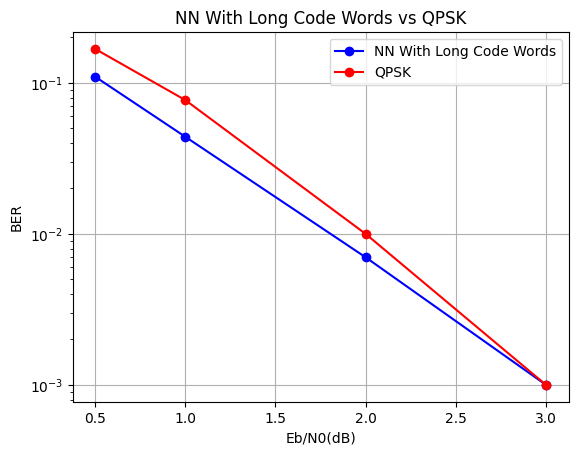

In [33]:
import matplotlib.pyplot as plt

# Define the points
x = [3, 2, 1, 0.5]
y = [0.001, 0.007, 0.044, 0.110]
x1 = [3, 2, 1, 0.5]
y1 = [0.001, 0.010, 0.077, 0.168]
# Create the plot
plt.plot(x, y, marker='o', linestyle='-', color = 'blue', label = 'NN With Long Code Words')
plt.plot(x1, y1, marker='o', linestyle='-', color = 'red', label = 'QPSK')
plt.yscale('log')
plt.legend()
# Add title and labels
plt.title('NN With Long Code Words vs QPSK')
plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
print(decoding_prob[0])
loss = criterion_reconstruction(decoding_prob, torch.from_numpy(batch_x).float())

In [60]:
# number_iterations = 1000
# for iteration in range(number_iterations):
#     number_steps_transmitter += 5000
#     number_steps_receiver += 5000
#     number_steps_channel += 2000
#     print("iteration is ", iteration)

#     ''' =========== Training the Channel Simulator ======== '''
#     for step in range(number_steps_channel):
#         if step % 100 == 0:
#             print("Training ChannelGAN, step is ", step)
        
#         ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
#         batch_x = generate_batch_data(int(batch_size))
#         # if step % 100 == 0:
#         #     print("Data : ", batch_x.shape)
#         channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
#         # if step % 100 == 0:
#         #     print("Channel Coded : ", channel_encoded.shape)
#         #     print("Channel Coded : ", channel_encoded[0])
#         input_data = modulator(channel_encoded, 4*2)
#         # if step % 100 == 0:
#         #     print("Modulation : ", input_data.shape)
#         input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, block_length))
#         # if step % 100 == 0:
#         #     print("Modulation + n : ", input_data.shape)

#         ## GENERATE CONDITIONAL INFO
#         h_r = torch.from_numpy(sample_h([batch_size, 1]))
#         h_i = torch.from_numpy(sample_h([batch_size, 1]))
#         reshaped_h_r = h_r.view(-1, 1, 1)
#         reshaped_h_i = h_i.view(-1, 1, 1)
#         concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
#         channel_info = concatenated_tensors.repeat(1, block_length, 1).transpose(-1,-2)
#         # if step % 100 == 0:
#         #     print("Channel Info : ", channel_info.shape)
#         condition = torch.cat((input_data, channel_info), axis=-2)
#         # if step % 100 == 0:
#         #     print("Conditions : ", condition.shape)
        
#         ## GENERATE NOISE LAYER FOR GENERATOR
#         noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
#         Z = sample_z(sample_size=[batch_size, Z_dim_c, block_length])
#         # if step % 100 == 0:
#         #     print("Noise : ", Z.shape)

#         ## GENERATOR FORWARD
#         G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
#         if step % 100 == 0:
#             #print("Generator Output : ", G_sample.shape)
#             print("Generator Output : ", G_sample[0])

#         ## NOISE LAYER FORWARD
#         R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
#         if step % 100 == 0:
#             #print("Noise Layer Output : ", R_sample.shape)
#             print("Noise Layer Output : ", R_sample[0])

#         ## DISCRIMINATOR FORWARD
#         D_prob_real, D_logit_real = discriminator(R_sample.float(), condition.float().detach())
#         D_prob_fake, D_logit_fake = discriminator(G_sample.float(), condition.float().detach())
#         if step % 100 == 0:
#             print("Discriminator Real Guess : ", D_prob_real)
#             print("Discriminator Fake Guess : ", D_prob_fake)

#         ## LOSS CRITERIA
#         D_loss_real = criterion_gan_r(D_logit_real, torch.ones_like(D_logit_real))
#         D_loss_fake = criterion_gan_f(D_logit_fake, torch.zeros_like(D_logit_fake))
#         D_loss = D_loss_real + D_loss_fake
#         if step % 100 == 0:
#             print("Discriminator Loss : ", D_loss)

#         ## DISCRIMINATOR BACKWARDS
#         optimizer_D.zero_grad()
#         D_loss.backward()
#         optimizer_D.step()


#         ## GENERATOR FORWARD
#         G_sample_new = generator(torch.from_numpy(Z).float().detach(), condition.float().detach())
#         D_prob_fake_new, D_logit_fake_new = discriminator(G_sample_new.float(), condition.float().detach())
#         G_loss = criterion_gan(D_logit_fake_new, torch.ones_like(D_logit_fake_new))
#         if step % 100 == 0:
#             print("Generator Loss : ", G_loss)
#             print("-------------------------------------------------")
#         ## GENERATOR BACKWARDS
#         optimizer_G.zero_grad()
#         G_loss.backward()
#         optimizer_G.step()

        
#     ''' =========== Training the Transmitter ==== '''
#     for step in range(number_steps_transmitter):
#         if step % 100 == 0:
#             print("Training transmitter, step is ", step)

        
#         ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
#         batch_x = generate_batch_data(int(batch_size))
#         if step % 100 == 0:
#             print("Data : ", batch_x[0])
#         channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
#         if step % 100 == 0:
#             # print("Channel Coded : ", channel_encoded.shape)
#             print("Channel Coded : ", channel_encoded[0])
#         input_data = modulator(channel_encoded, 4*2)
#         if step % 100 == 0:
#             print("Modulation : ", input_data[0])
#         input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, block_length))
#         # if step % 100 == 0:
#         #     print("Modulation + n : ", input_data.shape)

#         ## GENERATE CONDITIONAL INFO
#         h_r = torch.from_numpy(sample_h([batch_size, 1]))
#         h_i = torch.from_numpy(sample_h([batch_size, 1]))
#         reshaped_h_r = h_r.view(-1, 1, 1)
#         reshaped_h_i = h_i.view(-1, 1, 1)
#         concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
#         channel_info = concatenated_tensors.repeat(1, block_length, 1).transpose(-1,-2)
#         # if step % 100 == 0:
#         #     print("Channel Info : ", channel_info.shape)
#         condition = torch.cat((input_data, channel_info), axis=-2)
#         # if step % 100 == 0:
#         #     print("Conditions : ", condition.shape)
        
#         ## GENERATE NOISE LAYER FOR GENERATOR
#         noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
#         Z = sample_z(sample_size=[batch_size, Z_dim_c, block_length])
#         # if step % 100 == 0:
#         #     print("Noise : ", Z.shape)

#         ## GENERATOR FORWARD
#         G_sample = generator(torch.from_numpy(Z).float().detach(), condition.float())
#         if step % 100 == 0:
#             # print("Generator Output : ", G_sample.shape)
#             print("Generator Output : ", G_sample[0])


#         ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
#         decoding_prob, decoding_logit = demodulator(G_sample)
#         if step % 100 == 0:
#             print(" Demod Data: ", decoding_prob[0])
#         # if step % 100 == 0:
#         #     print(" Demodulated Shape : ", decoding_prob.shape)
#         rx_data = channel_decoder(decoding_prob)
#         # if step % 100 == 0:
#         #     print(" Channel Decode Shape : ", rx_data.shape)
        

#         ## LOSS CRITERIA
#         Tx_loss = criterion_reconstruction(rx_data, torch.from_numpy(batch_x).float())
#         if step % 100 == 0:
#             print(" Data Transmitted : ", batch_x[0])
#             print(" Data Received : ", rx_data[0])
#             print(" Tx_loss : ", Tx_loss)
#             print("--------------------------------------------")
        
#         ## TRANSMITTER BACKWARDS
#         optimizer_Tx.zero_grad()
#         Tx_loss.backward()
#         optimizer_Tx.step()
        
#     ''' ========== Training the Receiver ============== '''
#     for step in range(number_steps_receiver):
#         if step % 100 == 0:
#             print("Training receiver, step is ", step)

#         ## SAMPLE AND PASS DATA THROUGH CHANNEL ENCODE AND MODULATION
#         batch_x = generate_batch_data(int(batch_size))
#         if step % 100 == 0:
#             print("Data : ", batch_x[0])
#         channel_encoded = channel_encoder(torch.from_numpy(batch_x).float())
#         if step % 100 == 0:
#             # print("Channel Coded : ", channel_encoded.shape)
#             print("Channel Coded : ", channel_encoded[0])
#         input_data = modulator(channel_encoded, 4*2)
#         if step % 100 == 0:
#             print("Modulation : ", input_data[0])
#         input_data = input_data + torch.normal(0, 0.1, size=(int(batch_size), 2, block_length))
#         # if step % 100 == 0:
#         #     print("Modulation + n : ", input_data.shape)

#         ## GENERATE CONDITIONAL INFO
#         h_r = torch.from_numpy(sample_h([batch_size, 1]))
#         h_i = torch.from_numpy(sample_h([batch_size, 1]))
#         reshaped_h_r = h_r.view(-1, 1, 1)
#         reshaped_h_i = h_i.view(-1, 1, 1)
#         concatenated_tensors = torch.cat([reshaped_h_r, reshaped_h_i], dim=-1)
#         channel_info = concatenated_tensors.repeat(1, block_length, 1).transpose(-1,-2)
#         # if step % 100 == 0:
#         #     print("Channel Info : ", channel_info.shape)
#         condition = torch.cat((input_data, channel_info), axis=-2)
#         # if step % 100 == 0:
#         #     print("Conditions : ", condition.shape)
        
#         ## GENERATE NOISE LAYER FOR GENERATOR
#         noise_std = torch.sqrt(torch.tensor(1 / (2 * R * EbNo_train_GAN)))
#         Z = sample_z(sample_size=[batch_size, Z_dim_c, block_length])
#         # if step % 100 == 0:
#         #     print("Noise : ", Z.shape)

#         ## GENERATOR FORWARD
#         R_sample = rayleigh_noise_layer(input_data, h_r, h_i, noise_std)
#         if step % 100 == 0:
#             print("Rayleigh Layer Output : ", R_sample.shape)
#             print("Rayleigh Layer Output : ", R_sample[0])


#         ## PASS THROUGH CHANNEL DECODER AND DEMODULATION
#         decoding_prob, decoding_logit = demodulator(R_sample.float())
#         if step % 100 == 0:
#             print(" Demod Data: ", decoding_prob[0])
#         # if step % 100 == 0:
#         #     print(" Demodulated Shape : ", decoding_prob.shape)
#         rx_data = channel_decoder(decoding_prob)
#         # if step % 100 == 0:
#         #     print(" Channel Decode Shape : ", rx_data.shape)
        

#         ## LOSS CRITERIA
#         Rx_loss = criterion_reconstruction(rx_data, torch.from_numpy(batch_x).float())
#         if step % 100 == 0:
#             print(" Data Transmitted : ", batch_x[0])
#             print(" Data Received : ", rx_data[0])
#             print(" Rx_loss : ", Rx_loss)
#             print("--------------------------------------------")
        
#         ## TRANSMITTER BACKWARDS
#         optimizer_Rx.zero_grad()
#         Rx_loss.backward()
#         optimizer_Rx.step()

iteration is  0
Training ChannelGAN, step is  0
Generator Output :  tensor([[ 0.3914, -0.4666, -0.6343, -0.2010],
        [-2.4749, -2.5255, -2.5378, -2.4795]], grad_fn=<SelectBackward0>)
Noise Layer Output :  tensor([[ 2.2386,  2.3798,  2.3099,  1.1335],
        [-0.5205,  0.7125,  0.1401, -1.9668]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Discriminator Real Guess :  tensor([[0.0324]], grad_fn=<SigmoidBackward0>)
Discriminator Fake Guess :  tensor([[0.0566]], grad_fn=<SigmoidBackward0>)
Discriminator Loss :  tensor(3.4878, grad_fn=<AddBackward0>)
Generator Loss :  tensor(2.6826, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
-------------------------------------------------
Training ChannelGAN, step is  100
Generator Output :  tensor([[-1.0628, -0.5114, -0.5654, -1.2226],
        [-0.1074,  0.1697,  0.2860,  0.0099]], grad_fn=<SelectBackward0>)
Noise Layer Output :  tensor([[ 1.1497,  0.7388, -0.7728,  0.0960],
        [ 0.1745,  0.7571,  0.7480,  1.0893]], dtype=torc

KeyboardInterrupt: 